# Comparisons with existing ML solutions (full dataset no ignored columns)

You must run this notebook only if the notebook [`01-prepare-data.ipynb`](./01-prepare-data.ipynb) has been ran.
We rely on the existence of the pre-processed dataset files to run the model.

## Data preparation

First, we load the dataset from the CSV. **This time we will use the FULL dataset, with no columns dropped**

In [1]:
import pandas as pd

data = pd.read_csv('data/full_dataset.csv')
print(data.head())

   Rating  Seating Capacity  Average Meal Price  Chef Experience Years  \
0     4.0                38               73.98                     13   
1     3.2                76               28.11                      8   
2     4.7                48               48.29                     18   
3     4.4                34               51.55                     13   
4     4.9                88               75.98                      9   

   Number of Reviews  Avg Review Length  Ambience Score  \
0                185         161.924906             1.3   
1                533         148.759717             2.6   
2                853          56.849189             5.3   
3                 82         205.433265             4.6   
4                 78         241.681584             8.6   

   Service Quality Score  Weekend Reservations  Weekday Reservations  ...  \
0                    7.0                    13                     4  ...   
1                    3.4                    48

After loading the data, we need to perform some immediate pre-processing. We cannot (in a simple way) load the already scaled values from the dataset, as we'll not be able to descale them back (in a simple way), so let's scale the columns right here.

We have the boolean and integer values in our dataset, need to convert everything to a consistent data type.

In [2]:
data = data.astype(float)
print(data.head())

   Rating  Seating Capacity  Average Meal Price  Chef Experience Years  \
0     4.0              38.0               73.98                   13.0   
1     3.2              76.0               28.11                    8.0   
2     4.7              48.0               48.29                   18.0   
3     4.4              34.0               51.55                   13.0   
4     4.9              88.0               75.98                    9.0   

   Number of Reviews  Avg Review Length  Ambience Score  \
0              185.0         161.924906             1.3   
1              533.0         148.759717             2.6   
2              853.0          56.849189             5.3   
3               82.0         205.433265             4.6   
4               78.0         241.681584             8.6   

   Service Quality Score  Weekend Reservations  Weekday Reservations  ...  \
0                    7.0                  13.0                   4.0  ...   
1                    3.4                  48.0

Now we rescale the inputs, but there exist a catch.
To properly calculate the absolute error, we need original, unscaled values of the output.

But we split the dataset to training and testing sections at random.

These two processes - rescaling and train/test splitting interfere with each other.
So, we will use the simplest good enough approach: we rescale everything and will perform all operations on scaled data.

If we want to actually *use* the model for actual predictions based on user-submitted values, we'll need to keep the scaling parameters together with all the model parameters, because we'll need to scale the user-provided input and then de-scale the predicted output before returning to the user.

In [3]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

# list of columns for the full dataset
columns_to_normalize = ['Seating Capacity', 'Average Meal Price', 'Weekend Reservations', 'Weekday Reservations', 'Marketing&Followers', 'Chef Experience Years', 'Number of Reviews', 'Avg Review Length', 'Ambience Score', 'Service Quality Score', 'Rating']
data[columns_to_normalize] = scaler.fit_transform(data[columns_to_normalize])

revenue_scaler = StandardScaler()
scaled_revenues = revenue_scaler.fit_transform(data['Revenue'].values.reshape(-1, 1))

data['Revenue'] = scaled_revenues


OK now let's split the dataset to training and testing 80:20

In [4]:
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)


After splitting the dataset, we need to split them further to inputs and outputs. Here we immediately translate Pandas data frames to Numpy arrays using the `.values` property, as our `NeuralNet` object operates on Numpy arrays.

## Scikit

First, let's use the multi-linear regression from scikit-learn

In [5]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Separate the inputs and outputs
X_train = train_data.drop(columns=['Revenue']).values
y_train = train_data['Revenue'].values
X_test = test_data.drop(columns=['Revenue']).values
y_test = test_data['Revenue'].values

# Create and train the model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test).reshape(-1, 1)


I am using the absolutely barebones model with all parameters being the default.

In [6]:
from sklearn.metrics import mean_absolute_error
import numpy as np

# Calculate and print the mean squared error
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")
# Calculate and print the mean absolute error
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error: {mae}")

# Calculate the mean absolute percentage error
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
print(f"Mean Absolute Percentage Error: {mape}%")

Mean Squared Error: 0.044659578791165666
Mean Absolute Error: 0.1616095533176301
Mean Absolute Percentage Error: 568.3042345789765%


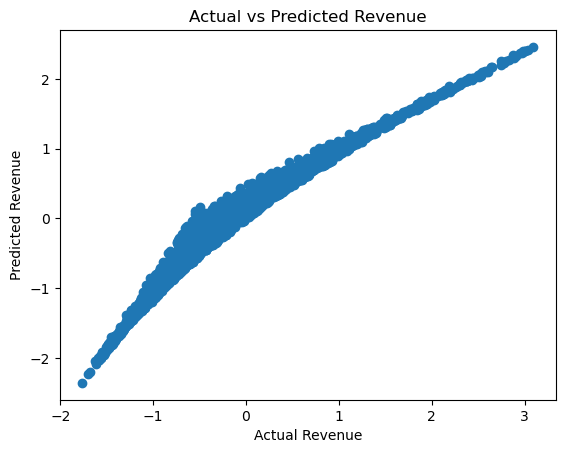

In [7]:
import matplotlib.pyplot as plt

plt.scatter(y_test, y_pred)
plt.xlabel('Actual Revenue')
plt.ylabel('Predicted Revenue')
plt.title('Actual vs Predicted Revenue')
plt.show()

## Pytorch

Now we do the same but using the neural network from Pytorch

In [8]:
import torch

import torch.nn as nn
import torch.optim as optim

# Define the neural network architecture
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

# Set the parameters
input_size = X_train.shape[1]
hidden_size = 64
output_size = 1
num_epochs = 100
learning_rate = 0.001

# Convert the data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)

# Initialize the model, loss function, and optimizer
model = NeuralNet(input_size, hidden_size, output_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-6)

# Train the model
for epoch in range(num_epochs):
    model.train()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Make predictions
model.eval()
with torch.no_grad():
    y_pred_tensor = model(X_test_tensor)
    y_pred = y_pred_tensor.numpy().reshape(-1, 1)


Epoch [10/100], Loss: 0.7587
Epoch [20/100], Loss: 0.5620
Epoch [30/100], Loss: 0.3923
Epoch [40/100], Loss: 0.2525
Epoch [50/100], Loss: 0.1531
Epoch [60/100], Loss: 0.0931
Epoch [70/100], Loss: 0.0603
Epoch [80/100], Loss: 0.0440
Epoch [90/100], Loss: 0.0355
Epoch [100/100], Loss: 0.0294


Mean Squared Error: 0.02862927701612824
Mean Absolute Error: 0.1323035417976886
Mean Absolute Percentage Error: 563.5590045415717%


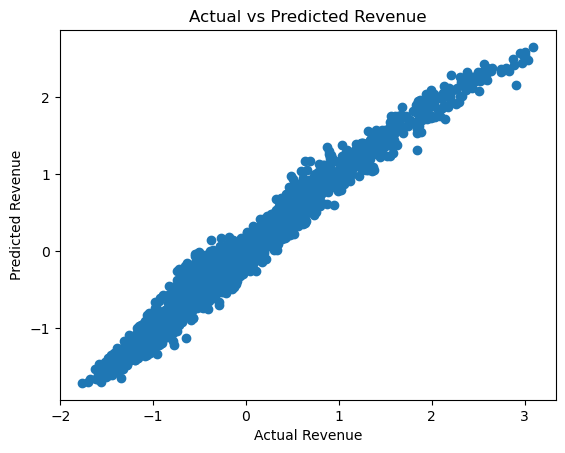

In [9]:

# Calculate the mean squared error, mean absolute error, and mean absolute percentage error
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")
print(f"Mean Absolute Percentage Error: {mape}%")

# Plot the scatter plot of actual vs predicted revenue
plt.scatter(y_test, y_pred)
plt.xlabel('Actual Revenue')
plt.ylabel('Predicted Revenue')
plt.title('Actual vs Predicted Revenue')
plt.show()

## Conclusions

With the full dataset, with no ignored columns such as "Parking Availability" or "Avg Review Length", we got not just the same results as with reduced dataset, but we even increased the error slightly.

With the reduced dataset, precise MAPE was 8.195% for the multilinear regressor and 6.429% for the pytorch neural network.

Here we got 8.202% for the multilinear regressor and 6.634% for pytorch neural network.

It seems that our guesses about the importance of these columns were correct in the [`01-prepare-data.ipynb`](./01-prepare-data.ipynb) and removing them was a correct approach.

There's no need to compare with the homemade NeuralNet class as it's not approximating the data correctly anyway.


| Model | MSE  | MAE  | MAPE  |
|-------|-----:|-----:|------:|
| sklearn.linear_model.LinearRegression | 3193229601.1717577 |  43214.032260596316 | 8.20267706690263% |
| torch.nn                              | 2675476086.469218 |  39083.58120743727 | 6.6348874985546855% |